<h1>Customer Lifetime Value With Probabilistic Model</h1>

<img src="https://mllehmdz0sx3.i.optimole.com/w:1600/h:412/q:mauto/f:best/ig:avif/https://fraudblocker.com/wp-content/uploads/2024/01/Lifetime-Value-LTV.jpg" alt="Customer Lifetime Value" width="1000" height="1000">

### Business Problem

- An online betting company would like to know each customer lifetime value for 6 months and 12 months periods.
- We will utilize one of the Buy Till You Die model BG/NBD for predicting deposit amounts and then used Gamma-Gamma model to predict Customer Lifetime Value for desired periods. 

### Importing Libraries

In [182]:
# pip install lifetimes

In [183]:
# pip install seaborn

In [184]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

### Reading Data

In [185]:
query = """
select * from pokermem.tbl_transaction limit 100;
select * from pokermem.tbl_moneytype limit 100;
select distinct MTY_cDirection from pokermem.tbl_moneytype;
select MTY_cName, count(1) from pokermem.tbl_moneytype group by MTY_cName;

select
	count(1),
	avg(transaction_cnt)
from
	(
	select
		player_id,
		day_id,
		transaction_type,
		round(avg(amount), 2) as avg_amount,
		sum(amount) as tot_amount,
		count(date_id) as transaction_cnt
	from
		(
		select
			case
				when m.MTY_cDirection = 'deposit' then t.tra_ply_iID_from
				else t.tra_ply_iID_to
			end as player_id,
			date(t.TRA_dAccounting) as day_id,
			t.TRA_dAccounting as date_id,
			m.MTY_cDirection as transaction_type,
			t.TRA_iAmount as amount
		from
			pokermem.tbl_transaction t
		left join pokermem.tbl_moneytype m
on
			t.TRA_MTY_iID = m.MTY_iID
		where
			date(t.TRA_dAccounting) >= '2020-01-01'
			and t.TRA_iAmount > 0
			and (m.MTY_iID between 1000 and 1999
				and m.MTY_cDirection = 'deposit'
				or m.MTY_iID between 2000 and 2999
				and m.MTY_cDirection = 'withdraw')
) tbl
	group by
		player_id,
		day_id,
		transaction_type
	order by
		player_id,
		day_id,
		transaction_type
) tbl2
"""

"""SDG Players Only"""
"""MIR"""
# test ones select p.PLY_iHousePlayer = 4 from pokermem.player as p limit 10;
# exclude test players and house players and agent players player_type, Custodial and Non-custodial also


'MIR'

In [186]:
new_query = """
with transactions as 
(
select
		player_id,
		day_id,
		transaction_type,
		round(avg(amount), 2) as avg_amount,
		sum(amount) as tot_amount,
		count(date_id) as transaction_cnt
from
		(
	select
			case
				when m.MTY_cDirection = 'deposit' then t.tra_ply_iID_from
			else t.tra_ply_iID_to
		end as player_id,
			date(t.TRA_dAccounting) as day_id,
			t.TRA_dAccounting as date_id,
			m.MTY_cDirection as transaction_type,
			t.TRA_iAmount as amount
	from
			pokermem.tbl_transaction t
	left join pokermem.tbl_moneytype m
        on
			t.TRA_MTY_iID = m.MTY_iID
	where
			date(t.TRA_dAccounting) >= '2000-01-01'
		and t.TRA_iAmount > 0
		and (m.MTY_iID between 1000 and 1999
			and m.MTY_cDirection = 'deposit'
			or m.MTY_iID between 2000 and 2999
			and m.MTY_cDirection = 'withdraw')
) tbl
group by
		player_id,
		day_id,
		transaction_type
order by
		player_id,
		day_id,
		transaction_type
),
money_type as 
(
select
	PLY_iID,
	PLY_Currency_alpha3
from
	player
)
select
	tran.*,
	mt.PLY_iID,
	mt.PLY_Currency_alpha3,
	pt.name
from
	transactions tran
left join money_type mt
on
	tran.player_id = mt.PLY_iID
left join pokermem.player p
  on
	tran.player_id = p.PLY_iID
left join pokermem.player_type pt
  on
	p.PLY_iHousePlayer = pt.value
where
	player_id is not null
	and pt.name not in ('Houseplayer', 'Custodial', 'Non-custodial', 'Testplayer');
"""

In [187]:
# player_id	day_id	transaction_type	avg_amount	tot_amount	transaction_cnt	PLY_iID	PLY_Currency_alpha3	name

In [188]:
#data = pd.read_csv(r"Result - 1 2025-09-12 10-06-08.csv.zip", compression = 'zip')
data = pd.read_csv(r"Result - 1 2025-09-12 13-38-35.csv.zip", compression = 'zip') # stete = 4 then ticket = won

data = data[data["player_id"].notnull()]
data = data[data["betAmountReal"]>0]
data["player_id"] = data["player_id"].astype('int64')
data["day_id"] = pd.to_datetime(data["day_id"])

data.head(5)

,player_id,bet_type,day_id,betCount,betAmountReal,winAmountReal
0,2,casino,2019-08-30,9,425,572
1,2,casino,2019-09-02,3,75,4
2,2,casino,2019-09-04,1,125,1025
3,2,casino,2019-09-10,2,250,950
4,2,casino,2020-03-11,2,200,0


In [189]:
data.shape

(3292419, 6)

In [190]:
data.player_id.nunique()

79387

In [191]:
dd = data.pivot_table(index="player_id", columns="bet_type", values="betAmountReal", aggfunc="count").reset_index()
dd.casino.mean(), dd.sports.mean()

(np.float64(27.003162270837592), np.float64(42.33927418313315))

In [192]:
data = data.drop(columns = ["bet_type", "winAmountReal"])

In [193]:
data.columns = ["player_id", "day_id", "transaction_cnt", "tot_amount"]

In [194]:
# Singaporian Currency Only
# data = data[data["PLY_Currency_alpha3"]=="SGD"]
# data = data[data["day_id"] >= "2024-01-01"]

In [195]:
# data.groupby("name").avg_amount.mean().round(0)

In [196]:
data[data["player_id"]==223783]

,player_id,day_id,transaction_cnt,tot_amount
1482484,223783,2023-10-13,1,800
1482485,223783,2023-10-24,3,60
1482486,223783,2023-12-07,2,240
1482487,223783,2023-12-26,2,80
1482488,223783,2023-12-29,3,120
1482489,223783,2024-01-03,11,2740
1482490,223783,2024-01-10,34,19340
1482491,223783,2024-02-07,1,100
1482492,223783,2024-03-12,1,50
1482493,223783,2024-04-22,1,80


In [197]:
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=200)

# data.groupby("day_id").tot_amount.sum().plot()

In [198]:
data.groupby("day_id").tot_amount.sum().to_clipboard()

In [199]:
data.groupby("player_id").agg({"tot_amount": 'sum', "day_id":'count'}).reset_index().sort_values(by="tot_amount", ascending = False).head(50)

,player_id,tot_amount,day_id
58024,367710,20531616400,20
43142,268788,19896262727,21
56500,354759,16691973300,13
70985,554456,15004100000,6
55493,348156,13683480700,8
56409,354121,11817833300,17
72267,569966,11618564800,1
26919,167815,11344565765,533
36295,228427,11339290092,573
56037,351587,10973592000,10


In [200]:
data.shape

(3292419, 4)

In [201]:
data.player_id.nunique()

79387

In [202]:
# data["transaction_type"].value_counts()
# data.groupby("transaction_type").tot_amount.sum()

In [203]:
# dd = data.pivot_table(index = "day_id", columns="transaction_type", values="tot_amount", aggfunc="sum")
# dd["wdr_rate"] = dd["withdraw"]/dd["deposit"]
# dd.wdr_rate.mean()

In [204]:
# # Deposits only
# data = data[data["transaction_type"]=="deposit"]

In [205]:
# bm["msisdn_1"] = bm["bundle_msisdn"]
data["player_id_1"] = data["player_id"]

In [206]:
data = data[["player_id", "day_id", "player_id_1", "tot_amount"]]
data.sample(3)

,player_id,day_id,player_id_1,tot_amount
2279035,12397,2023-08-28,12397,20000
1488961,224522,2023-10-07,224522,16320
49320,479,2024-06-15,479,374060


In [207]:
# bm.columns = ["msisdn", "day_id", "msisdn_1", "bundle_fee"]

#### Preprocess the data

In [208]:
import datetime
from dateutil.relativedelta import relativedelta

In [209]:
data["day_id_new"] = data["day_id"]

In [210]:
data.day_id.isna().sum()

np.int64(0)

In [211]:
data = data[data["day_id"].notna()]

In [212]:
# data["day_id"] = data["day_id"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))

In [213]:
data["month_id"]=data.day_id.apply(lambda x: str(x)[:7])

In [214]:
data.sample(3)

,player_id,day_id,player_id_1,tot_amount,day_id_new,month_id
1730242,287915,2024-08-04,287915,1150288,2024-08-04,2024-08
2178952,6087,2022-10-14,6087,4937,2022-10-14,2022-10
419256,12296,2022-02-07,12296,179497,2022-02-07,2022-02


In [215]:
# data["quarter"] = pd.PeriodIndex(data['day_id'] ,freq='Q')
data["month"] = pd.PeriodIndex(data['day_id'] ,freq='M')

In [216]:
data["tot_amount"].isna().sum()

np.int64(0)

In [217]:
data["tot_amount"] = np.where(data["tot_amount"].isna(), 0, data["tot_amount"])

In [218]:
data.sample(5)

,player_id,day_id,player_id_1,tot_amount,day_id_new,month_id,month
3215455,316291,2025-04-30,316291,9776,2025-04-30,2025-04,2025-04
1914705,435418,2025-02-04,435418,27200,2025-02-04,2025-02,2025-02
1252212,167349,2023-03-13,167349,10040,2023-03-13,2023-03,2023-03
552958,18529,2025-07-30,18529,365388,2025-07-30,2025-07,2025-07
3228779,329794,2025-02-23,329794,15870,2025-02-23,2025-02,2025-02


In [219]:
# Day
data1 = data.groupby(["player_id", "day_id"]).agg(Quantity = ("player_id_1", 'count'),
                                                  UnitPrice = ("tot_amount", 'mean'),
                                                  InvoiceDate = ("day_id", 'min')).reset_index()
data1.sample(3)

,player_id,day_id,Quantity,UnitPrice,InvoiceDate
643725,13802,2024-11-23,1,5000.0,2024-11-23
2178194,226270,2023-12-10,1,48850.0,2023-12-10
291309,5050,2022-03-16,2,3110.0,2022-03-16


In [38]:
# Quarter, Month
data1 = data.groupby(["player_id", "month_id"]).agg(Quantity = ("player_id_1", 'count'),
                                                    UnitPrice = ("tot_amount", 'mean'),
                                                    InvoiceDate = ("day_id", 'min')).reset_index()
data1.sample(3)

,player_id,month_id,Quantity,UnitPrice,InvoiceDate
317987,295653,2024-08,1,720.000000,2024-08-17
378702,631629,2025-09,12,254619.666667,2025-09-01
62912,12017,2025-09,2,5000.000000,2025-09-09


In [39]:
data1.player_id.nunique()

79387

In [40]:
data1.columns = ["CustomerID", "day_id", "Quantity", "UnitPrice", "InvoiceDate"]

In [41]:
data1.sample(5)

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
274022,232030,2025-06,2,2.000000e+03,2025-06-06
205686,157994,2024-03,6,8.828000e+03,2024-03-02
311162,284724,2024-03,1,7.950400e+04,2024-03-29
356513,439088,2025-02,1,2.490000e+07,2025-02-03
2051,269,2021-05,3,3.113577e+05,2021-05-02


In [42]:
data1.CustomerID.nunique()

79387

#### Data Understanding

In [43]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate
0,2,2019-08,4,306.250,2019-08-16
1,2,2019-09,5,122.200,2019-09-02
2,2,2019-11,2,1339.000,2019-11-03
3,2,2020-02,1,100.000,2020-02-21
4,2,2020-03,8,235.625,2020-03-04


In [44]:
data1.shape

(379600, 5)

In [45]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379600 entries, 0 to 379599
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   379600 non-null  int64         
 1   day_id       379600 non-null  object        
 2   Quantity     379600 non-null  int64         
 3   UnitPrice    379600 non-null  float64       
 4   InvoiceDate  379600 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 14.5+ MB


In [46]:
data1.describe()

,CustomerID,Quantity,UnitPrice,InvoiceDate
count,379600.000000,379600.000000,3.796000e+05,379600
mean,161581.780448,8.673390,5.857157e+05,2024-01-22 03:05:11.822971136
min,2.000000,1.000000,1.000000e+00,2019-08-16 00:00:00
25%,20689.000000,1.000000,5.000000e+03,2023-04-01 00:00:00
50%,153307.000000,4.000000,2.051833e+04,2024-03-17 00:00:00
75%,247588.750000,12.000000,8.010792e+04,2025-01-01 00:00:00
max,639386.000000,62.000000,1.161856e+10,2025-09-12 00:00:00
std,149684.469561,10.161081,3.459991e+07,NaN


In [47]:
data1["UnitPrice"].min(), data1["UnitPrice"].max()

(np.float64(1.0), np.float64(11618564800.0))

In [48]:
# sns.distplot(data1.UnitPrice)

### Data Preprocessing

In [49]:
# df = df[df['Quantity'] > 0 ]
# df = df[df['UnitPrice'] > 0]
# df = df[~df['InvoiceNo'].str.contains("C",na=False)] # drop returned items

In [50]:
data1.shape, data1[data1['Quantity'] > 0 ].shape, data1[data1['UnitPrice'] > 0].shape

((379600, 5), (379600, 5), (379600, 5))

In [51]:
data1 = data1[data1['Quantity'] > 0 ]
data1 = data1[data1['UnitPrice'] > 0]
# bm1 = bm1[~bm1['InvoiceNo'].str.contains("C",na=False)] # drop returned items

#### Missing Values


In [52]:
data1.isna().sum()

CustomerID     0
day_id         0
Quantity       0
UnitPrice      0
InvoiceDate    0
dtype: int64

In [53]:
data1.CustomerID.nunique()

79387

#### Handling Outliers

In [54]:
def find_boundaries(df, variable, q1=0.05, q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary, lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [55]:
capping_outliers(data1,'UnitPrice')
capping_outliers(data1,'Quantity')

In [56]:
data1.CustomerID.nunique()

79387

#### Creating Column 'Total Price'

In [57]:
data1['Total Price'] = data1['UnitPrice'] * data1['Quantity']

In [58]:
data1.head()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate,Total Price
0,2,2019-08,4.0,306.250,2019-08-16,1225.0
1,2,2019-09,5.0,122.200,2019-09-02,611.0
2,2,2019-11,2.0,1339.000,2019-11-03,2678.0
3,2,2020-02,1.0,110.000,2020-02-21,110.0
4,2,2020-03,8.0,235.625,2020-03-04,1885.0


In [59]:
# data1[data1["CustomerID"]==133].InvoiceDate.value_counts()

In [60]:
# data1.CustomerID.value_counts().nlargest(50)

### Creating Summary Dataset

By using lifetimes we can also create our RFM data from the original dataset.

- **Frequency** represents the number of repeat deposits the customer has made. This means that it’s one less than the total number of deposits. This is actually slightly wrong. It’s the count of time periods the customer had a deposit in. So if using days as units, then it’s the count of days the customer had a deposit on.

- **Recency** represents the age of the customer when they made their most recent deposist. This is equal to the duration between a customer’s first deposit and their latest deposit. (Thus if they have made only 1 deposit, the recency is 0.)

- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first deposit and the end of the period under study.

- **Monetary_Value** represents the average value of a given customer’s deposists. This is equal to the sum of all a customer’s deposits divided by the total number of deposits. Note that the denominator here is different than the frequency described above.

In [61]:
# clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price', observation_period_end='2011-12-09')

In [62]:
data1.InvoiceDate.min(), data1.InvoiceDate.max()

(Timestamp('2019-08-16 00:00:00'), Timestamp('2025-09-12 00:00:00'))

In [63]:
clv_data1 = lifetimes.utils.summary_data_from_transaction_data(data1, 'CustomerID','InvoiceDate','Total Price', observation_period_end=data1.InvoiceDate.max())

In [64]:
# clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

In [65]:
clv_data1.shape, clv_data1[clv_data1['frequency']>1].shape

((79387, 4), (27964, 4))

In [80]:
clv_data1 = clv_data1[clv_data1['frequency']>1] # we want only customers shopped more than 2 times

In [81]:
clv_data1.head()

,frequency,recency,T,monetary_value,expected_bets_3_months
CustomerID,,,,,
2,40.0,2090.0,2219.0,1185.225000,0.049588
3,5.0,1473.0,2216.0,220.000000,0.004725
43,2.0,220.0,1642.0,305.000000,0.000363
123,3.0,316.0,1842.0,346.666667,0.000211
124,31.0,1508.0,1843.0,809539.198532,0.008676


<Axes: ylabel='Density'>

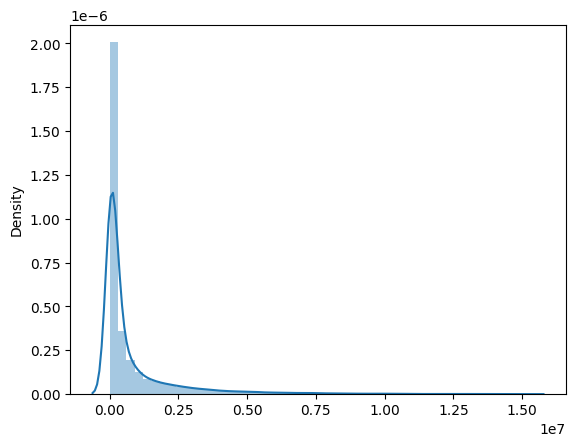

In [82]:
#sns.distplot(clv_data1["frequency"])
#sns.distplot(clv_data1["recency"])
#sns.distplot(clv_data1["T"])
sns.distplot(clv_data1[["monetary_value"]])

### BG/NBD Model for Predicting Number of Deposits

In [83]:
# bgf = BetaGeoFitter(penalizer_coef=0.001)
# bgf.fit(clv['frequency'], clv['recency'], clv['T'])

In [84]:
bgf_data1 = BetaGeoFitter(penalizer_coef=0.001)
bgf_data1.fit(clv_data1['frequency'], clv_data1['recency'], clv_data1['T'])

<lifetimes.BetaGeoFitter: fitted with 27964 subjects, a: 0.43, alpha: 194.23, b: 3.98, r: 3.64>

#### Summary of BG/NBD Model

In [85]:
# bgf.summary

In [86]:
bgf_data1.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.639287,0.041452,3.558041,3.720533
alpha,194.225789,2.381701,189.557654,198.893923
a,0.431012,0.006463,0.418345,0.443679
b,3.978773,0.071105,3.839408,4.118138


### Visualizing our Frequency/Recency Matrix

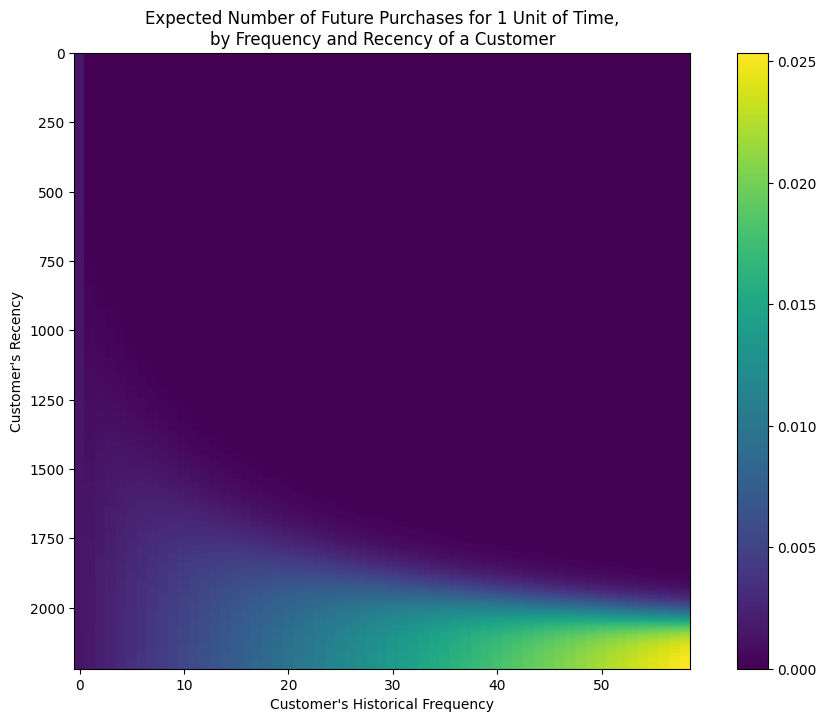

In [87]:
plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf_data1)
plt.show()

<h3>  🎯 Key Interpretations </h3>

1. <b> Bottom Right Corner (High Frequency, High Recency) — 🔥 Bright Yellow </b>

   These are customers who:

    1. Bought many times (high frequency)

    2. Made their last purchase recently (high recency)

    <b> Interpretation </b> : These are your most valuable and loyal customers — the model expects them to keep buying regularly.

    Expected purchases per unit time: ~0.025–0.030

2. <b> Top Left Corner (Low Frequency, Low Recency) — 🔮 Dark Purple </b>

    Customers with:

    1. Few or only one historical purchase

    2. Long time since their last purchase

    <b> Interpretation </b>: These are low-value, likely churned customers. Little to no expected future purchases.

4. <b> Middle Regions — Gradient </b>

    The transition from purple → blue → green → yellow shows:

    1. How expected future transactions grow as frequency increases and recency improves.

    2. This gradient reflects the model's probabilistic understanding of customer behavior.

#### Expected Number of Deposist in 3 Months

In [88]:
# t = 180 # 30 day period
# clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
# clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

In [89]:
t = 3 # 90 day period
clv_data1['expected_bets_3_months'] = bgf_data1.conditional_expected_number_of_purchases_up_to_time(t, clv_data1['frequency'], clv_data1['recency'], clv_data1['T'])
clv_data1.sort_values(by='expected_bets_3_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_bets_3_months
CustomerID,,,,,
2213,55.0,1657.0,1657.0,2.709048e+05,0.094294
478,57.0,1709.0,1718.0,3.723771e+06,0.094201
444,57.0,1709.0,1719.0,6.710094e+06,0.094123
4790,52.0,1563.0,1568.0,1.405560e+06,0.093824
3460,53.0,1591.0,1599.0,1.465484e+06,0.093791


In [90]:
clv_data1.reset_index().expected_bets_3_months.min(), clv_data1.reset_index().expected_bets_3_months.max()

(np.float64(1.9371663357574776e-09), np.float64(0.09429350730319538))

### Gamma - Gamma Model

The Gamma-Gamma Model can predict the most likely value per transaction in the future

#### Assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the deposit frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [91]:
# clv[['frequency','monetary_value']].corr()

At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [92]:
clv_data1[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.00000,0.28008
monetary_value,0.28008,1.00000


In [93]:
# ggf = GammaGammaFitter(penalizer_coef=0.01)
# ggf.fit(clv["frequency"],
#         clv["monetary_value"])

In [94]:
ggf_data1 = GammaGammaFitter(penalizer_coef=0.01)
ggf_data1.fit(clv_data1["frequency"],
              clv_data1["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 27964 subjects, p: 2.29, q: 0.10, v: 2.24>

### 6 months Customer Lifetime Value

In [95]:
# clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
#                                    clv["frequency"],
#                                    clv["recency"],
#                                    clv["T"],
#                                    clv["monetary_value"],
#                                    time=6,
#                                    freq='D',
#                                    discount_rate=0.01)

In [96]:
# clv.sort_values('6_Months_CLV',ascending=False).head()

In [97]:
clv_data1['3_Months_CLV']=ggf_data1.customer_lifetime_value(bgf_data1,
                                   clv_data1["frequency"],
                                   clv_data1["recency"],
                                   clv_data1["T"],
                                   clv_data1["monetary_value"],
                                   time=3,
                                   freq='M',
                                   discount_rate=0)

In [98]:
clv_data1.sort_values('3_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV
CustomerID,,,,,,
169193,31.0,932.0,943.0,1.392920e+07,0.089732,1.265919e+06
197138,29.0,858.0,869.0,1.267790e+07,0.090329,1.160889e+06
474325,6.0,181.0,192.0,1.515262e+07,0.070288,1.139549e+06
328268,13.0,400.0,411.0,1.385074e+07,0.079480,1.135111e+06
270829,13.0,383.0,394.0,1.331296e+07,0.081749,1.122180e+06


#### Segmentation Customers by 3 Months CLV

In [99]:
# clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
#                                                           'Loyal Customers','Champions'])

In [100]:
# Create labels dynamically: decile_1 ... decile_20
labels = [f"decile_{i}" for i in range(1, 21)]

# Apply qcut with 20 bins
# clv_data1['Segment'] = pd.qcut(
#     clv_data1['3_Months_CLV'],
#     q=20,
#     labels=labels
# )

clv_data1['Segment'] = pd.cut(
    clv_data1['3_Months_CLV'],
    bins=20,  # splits the value range into 20 equal intervals
    labels=labels
)

In [101]:
clv_data1.head()

,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV,Segment
CustomerID,,,,,,,
2,40.0,2090.0,2219.0,1185.225000,0.048849,58.473715,decile_1
3,5.0,1473.0,2216.0,220.000000,0.004665,1.116018,decile_1
43,2.0,220.0,1642.0,305.000000,0.000024,0.009112,decile_1
123,3.0,316.0,1842.0,346.666667,0.000014,0.005532,decile_1
124,31.0,1508.0,1843.0,809539.198532,0.006895,5653.074653,decile_1


In [102]:
clv_data1 = clv_data1.reset_index()
clv_data1.sample(3)

,CustomerID,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV,Segment
5708,24783,3.0,159.0,1203.0,153.666667,0.000021,0.003799,decile_1
10192,147339,9.0,1015.0,1024.0,336216.441959,0.029926,10520.226239,decile_1
12519,155574,31.0,1001.0,1009.0,855596.225806,0.084962,73624.474464,decile_2


### Final Dataframe

In [103]:
clv_data1.groupby('Segment').mean()

,CustomerID,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV
Segment,,,,,,,
decile_1,177505.500664,8.582662,494.911774,860.280702,4.320108e+05,0.022431,7.049779e+03
decile_2,198479.678233,19.143218,756.045426,799.731230,1.697665e+06,0.061929,9.062633e+04
decile_3,198741.321149,20.749347,768.536554,802.537859,2.456933e+06,0.067333,1.551650e+05
decile_4,193720.521186,22.847458,805.353814,834.141949,3.230240e+06,0.070891,2.189289e+05
decile_5,176884.682927,24.909408,853.526132,877.595819,3.861561e+06,0.074454,2.808381e+05
decile_6,177829.039801,25.194030,840.273632,866.019900,4.615198e+06,0.075742,3.445313e+05
decile_7,202377.268750,24.062500,807.087500,829.450000,5.413783e+06,0.075568,4.100230e+05
decile_8,223044.157303,22.831461,756.775281,774.674157,6.137915e+06,0.075849,4.709081e+05
decile_9,187940.093333,26.066667,850.973333,869.920000,6.697422e+06,0.079046,5.349953e+05


In [104]:
clv_data1.groupby('Segment').agg({"CustomerID":'count', "3_Months_CLV":'mean'}).reset_index()

,Segment,CustomerID,3_Months_CLV
0,decile_1,24086,7.049779e+03
1,decile_2,1585,9.062633e+04
2,decile_3,766,1.551650e+05
3,decile_4,472,2.189289e+05
4,decile_5,287,2.808381e+05
5,decile_6,201,3.445313e+05
6,decile_7,160,4.100230e+05
7,decile_8,89,4.709081e+05
8,decile_9,75,5.349953e+05
9,decile_10,52,5.999203e+05


In [105]:
clv_data1.groupby('Segment').agg({"CustomerID":'count', "3_Months_CLV":'mean'}).reset_index().round(0).to_clipboard()

### Group by Segment

In [106]:
#clv_data1.groupby('Segment').mean()

<Axes: xlabel='Segment'>

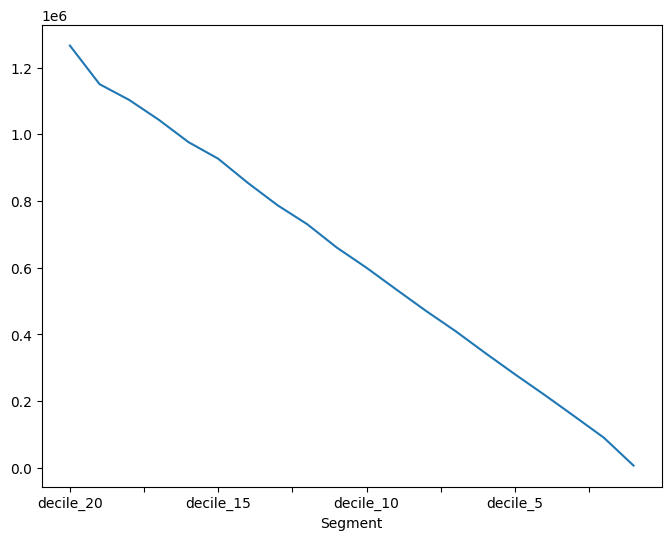

In [107]:
plt.figure(figsize=(8,6))
clv_data1.groupby('Segment').mean().round(0)["3_Months_CLV"][::-1].plot()
#clv_data1.groupby('Segment').count().round(0)["CustomerID"][::-1].plot()


# sns.lineplot(clv_data1.groupby('Segment').mean().round(0)["3_Months_CLV"][::-1])
# # Rotate x-axis labels
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()

In [108]:
clv_data1.sample()

,CustomerID,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV,Segment
4311,17158,3.0,347.0,1314.0,108180.0,0.0002,24.88999,decile_1


In [109]:
res = clv_data1.groupby("Segment").agg({"CustomerID":'count', 
                                          "frequency":'mean',	
                                          "recency":'mean',
                                          "T":'mean',
                                          "monetary_value": 'mean',
                                          "expected_bets_3_months":'mean',
                                          "3_Months_CLV":'mean'}).round(4).reset_index()#.to_clipboard(index=False)
res.to_clipboard()
res

,Segment,CustomerID,frequency,recency,T,monetary_value,expected_bets_3_months,3_Months_CLV
0,decile_1,24086,8.5827,494.9118,860.2807,4.320108e+05,0.0224,7.049779e+03
1,decile_2,1585,19.1432,756.0454,799.7312,1.697665e+06,0.0619,9.062633e+04
2,decile_3,766,20.7493,768.5366,802.5379,2.456933e+06,0.0673,1.551650e+05
3,decile_4,472,22.8475,805.3538,834.1419,3.230240e+06,0.0709,2.189289e+05
4,decile_5,287,24.9094,853.5261,877.5958,3.861561e+06,0.0745,2.808381e+05
5,decile_6,201,25.1940,840.2736,866.0199,4.615198e+06,0.0757,3.445313e+05
6,decile_7,160,24.0625,807.0875,829.4500,5.413783e+06,0.0756,4.100230e+05
7,decile_8,89,22.8315,756.7753,774.6742,6.137915e+06,0.0758,4.709081e+05
8,decile_9,75,26.0667,850.9733,869.9200,6.697422e+06,0.0790,5.349953e+05
9,decile_10,52,26.0385,836.8269,851.0577,7.228370e+06,0.0820,5.999203e+05


In [110]:
def distribution_analysis(attr, agg_col, df: pd.DataFrame):
    # Get unique labels in the aggregation column
    unique_labels = df[agg_col].dropna().unique()
    
    # Create a color palette with as many colors as labels
    palette = sns.color_palette("tab10", n_colors=len(unique_labels))

    plt.figure(figsize=(10, 6))

    # Loop through labels and plot KDE for each
    for i, label in enumerate(unique_labels):
        filtered = df[
            (df[agg_col] == label) &
            (df[attr] < df[attr].quantile(0.95)) &
            (df[attr] > df[attr].quantile(0.05))
        ]
        if not filtered.empty:
            sns.kdeplot(filtered[attr], label=str(label), color=palette[i], fill=True)

    plt.title(f"Distribution of: {attr} by: {agg_col}")
    
    plt.xlabel(attr)
    plt.ylabel("Density")
    plt.legend(title=agg_col)
    plt.tight_layout()
    plt.show()

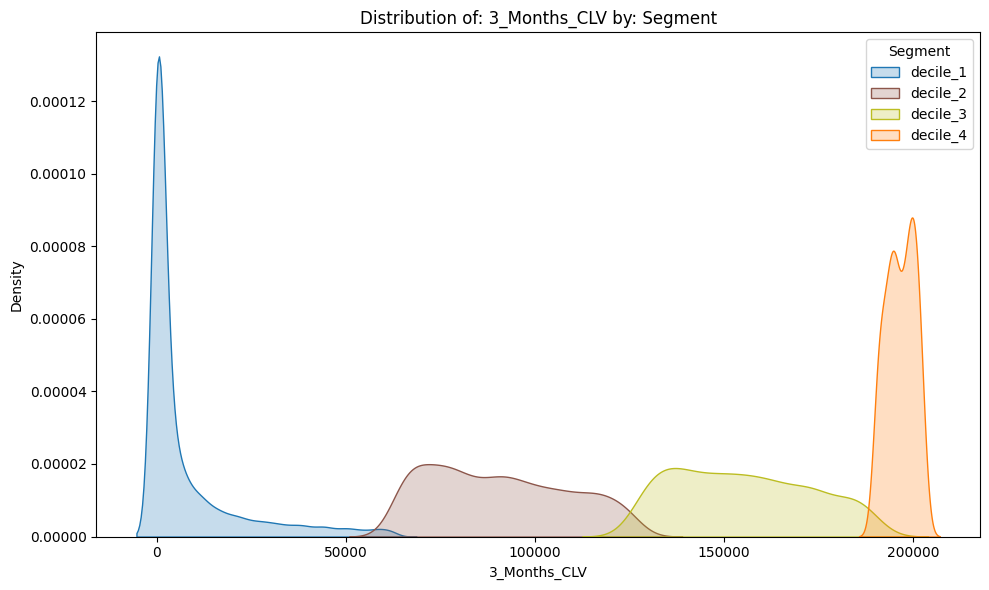

In [111]:
distribution_analysis("3_Months_CLV", "Segment", clv_data1.reset_index())

### Thank you

In [112]:
# Deposit - Withdrawals

### Expected Number of Deposist in 3 Months - Version 2 (Inclued also the customers with no frequency)

In [113]:
data1.sample()

,CustomerID,day_id,Quantity,UnitPrice,InvoiceDate,Total Price
203487,157343,2022-12,23.0,31681.565217,2022-12-14,728676.0


In [114]:
import pandas as pd
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

summary = summary_data_from_transaction_data(
    data1,
    customer_id_col='CustomerID',
    datetime_col='day_id',
    monetary_value_col='UnitPrice',       # your revenue column
    observation_period_end=data1['day_id'].max(),
    #freq='M'                           # keep daily; can scale later
)

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary['pred_bets_3m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    3,  # 3 months
    summary['frequency'],
    summary['recency'],
    summary['T']
)

repeaters = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]

ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(repeaters['frequency'], repeaters['monetary_value'])

summary['pred_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# for frequency == 0
summary['pred_avg_value'] = summary['pred_avg_value'].fillna(summary['monetary_value'].fillna(0))

# 
summary['CLV_3m'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=3,                # forecast horizon in months
    discount_rate=0     # monthly discount rate if available
)

summary['CLV_3m'] = summary['CLV_3m'].fillna(summary['monetary_value'].fillna(0))

summary = summary.reset_index()

summary[['frequency', 'recency', 'T', 'pred_bets_3m', 'pred_avg_value', 'CLV_3m']].head()

,frequency,recency,T,pred_bets_3m,pred_avg_value,CLV_3m
0,40.0,2100.0,2223.0,0.049482,2202.413908,3248.155217
1,5.0,1461.0,2223.0,0.004573,14880.824420,2029.706238
2,0.0,0.0,2192.0,0.000383,528398.621668,6045.768873
3,1.0,30.0,2192.0,0.000086,66594.709474,171.314724
4,0.0,0.0,2162.0,0.000388,528398.621668,6128.017130


In [130]:
# Create labels dynamically: decile_1 ... decile_20
labels = [f"decile_{i}" for i in range(1, 21)]

# qcut with 20 bins
# clv_data1['Segment'] = pd.qcut(
#     clv_data1['3_Months_CLV'],
#     q=20,
#     labels=labels
# )

summary['Segment'] = pd.cut(
    summary['CLV_3m'],
    bins=20,  # splits the value range into 20 equal intervals
    labels=labels
)
res = summary.groupby("Segment").agg({"CustomerID":'count', 
                                      "frequency":'mean',	
                                      "recency":'mean',
                                      "T":'mean',
                                      "monetary_value": 'mean',
                                      "pred_bets_3m":'mean',
                                      "CLV_3m":'mean'}).round(4).reset_index()#.to_clipboard(index=False)
res.to_clipboard()
res.sort_values('CLV_3m',ascending=True)

,Segment,CustomerID,frequency,recency,T,monetary_value,pred_bets_3m,CLV_3m
0,decile_1,65546,2.7024,171.3897,724.5430,20206.6593,0.0074,2.297456e+04
1,decile_2,7850,5.2600,230.7952,312.2768,35393.2910,0.0241,1.024349e+05
2,decile_3,2596,8.7377,363.3910,399.7623,70832.2902,0.0372,1.872359e+05
3,decile_4,748,19.0348,752.2179,780.6537,159229.5727,0.0653,2.647753e+05
4,decile_5,1060,10.1425,387.5387,400.4217,99888.2302,0.0465,3.385913e+05
5,decile_6,390,20.2385,753.4974,778.5615,229536.2430,0.0691,4.207084e+05
6,decile_7,260,20.3923,743.3269,764.4654,256032.2933,0.0710,4.953017e+05
7,decile_8,209,23.6124,833.7895,849.7368,269964.8938,0.0759,5.729475e+05
8,decile_9,162,21.7654,779.6173,796.2160,302096.7948,0.0761,6.479406e+05
9,decile_10,139,18.2230,638.1079,646.7842,374863.8009,0.0718,7.226455e+05


In [132]:
res["pred_bets_3m"]*90

0     0.666
1     2.169
2     3.348
3     5.877
4     4.185
5     6.219
6     6.390
7     6.831
8     6.849
9     6.462
10    7.047
11    7.524
12    7.398
13    7.893
14    7.641
15    7.875
16    7.974
17    8.172
18    8.334
19    8.415
Name: pred_bets_3m, dtype: float64

In [116]:
summary.shape, summary[summary["monetary_value"]==0].shape

((79387, 9), (41054, 9))

In [117]:
summary["pred_bets_3m"].min(), summary["pred_bets_3m"].mean(), summary["pred_bets_3m"].max()

(np.float64(4.639631342500615e-09),
 np.float64(0.012405321363175662),
 np.float64(0.09660447468061956))

In [118]:
summary["CLV_3m"].min(), summary["CLV_3m"].mean(), summary["CLV_3m"].max()

(np.float64(0.000802662940323121),
 np.float64(55322.925870805244),
 np.float64(1531295.331336829))

In [119]:
summary["monetary_value"].min(), summary["monetary_value"].mean(), summary["monetary_value"].max()

(np.float64(0.0), np.float64(31464.35009676061), np.float64(547684.9776280323))

In [120]:
summary[summary["monetary_value"]==0].CLV_3m.min(), summary[summary["monetary_value"]==0].CLV_3m.mean(), summary[summary["monetary_value"]>0].CLV_3m.max()

(np.float64(6045.768872503493),
 np.float64(47292.09678017911),
 np.float64(1531295.331336829))

In [121]:
summary.sort_values(by = "monetary_value", ascending=False).monetary_value.value_counts()

monetary_value
0.000000         41054
110.000000        2093
547684.977628      446
200.000000          68
10000.000000        62
                 ...  
351009.155481        1
350950.539494        1
110.500000           1
350900.000000        1
543417.138844        1
Name: count, Length: 32844, dtype: int64

# Cohort Analysis

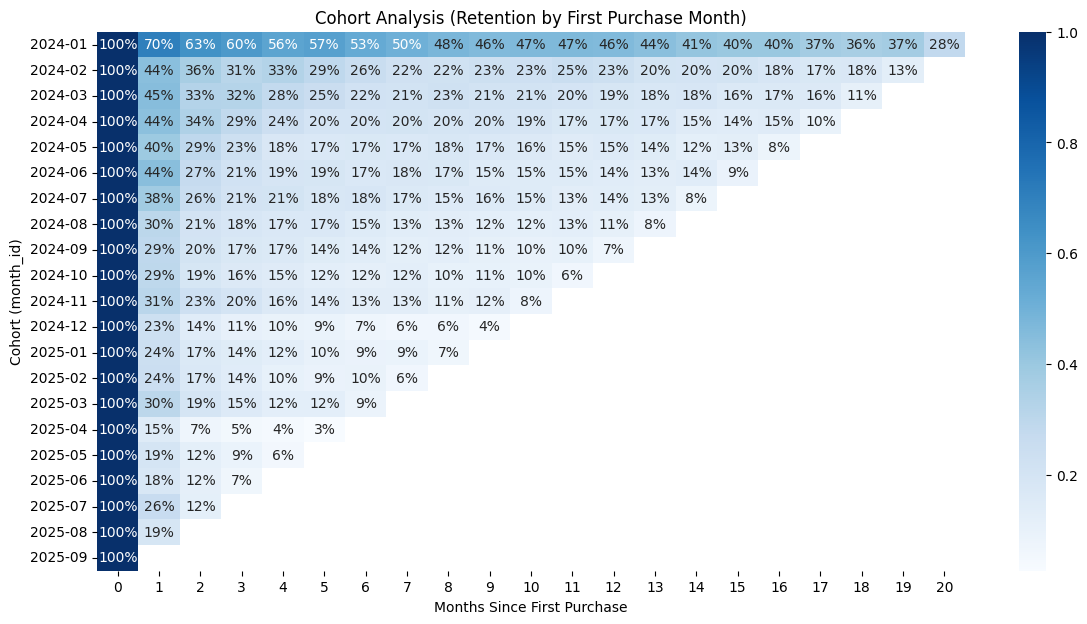

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format="%Y-%m")

data = data[data['day_id'] >= "2023-01-01"]

# Create cohort_month = player's first purchase month
data['cohort_month'] = data.groupby('player_id')['month_id'].transform('min')

# Cohort index is the months since first purchase
data['cohort_index'] = ((data['month_id'].dt.year - data['cohort_month'].dt.year) * 12 +
                        (data['month_id'].dt.month - data['cohort_month'].dt.month))

cohort_data = (data.groupby(['cohort_month', 'cohort_index'])['player_id']
                  .nunique()
                  .reset_index())

cohort_pivot = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='player_id'
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

plt.figure(figsize=(14,7))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")

plt.yticks(
    ticks=[i + 0.5 for i in range(len(retention.index))],  # center tick labels
    labels=[d.strftime("%Y-%m") for d in retention.index], # format as YYYY-MM
    rotation=0
)

plt.title("Cohort Analysis (Retention by First Purchase Month)")
plt.ylabel("Cohort (month_id)")
plt.xlabel("Months Since First Purchase")
plt.show()


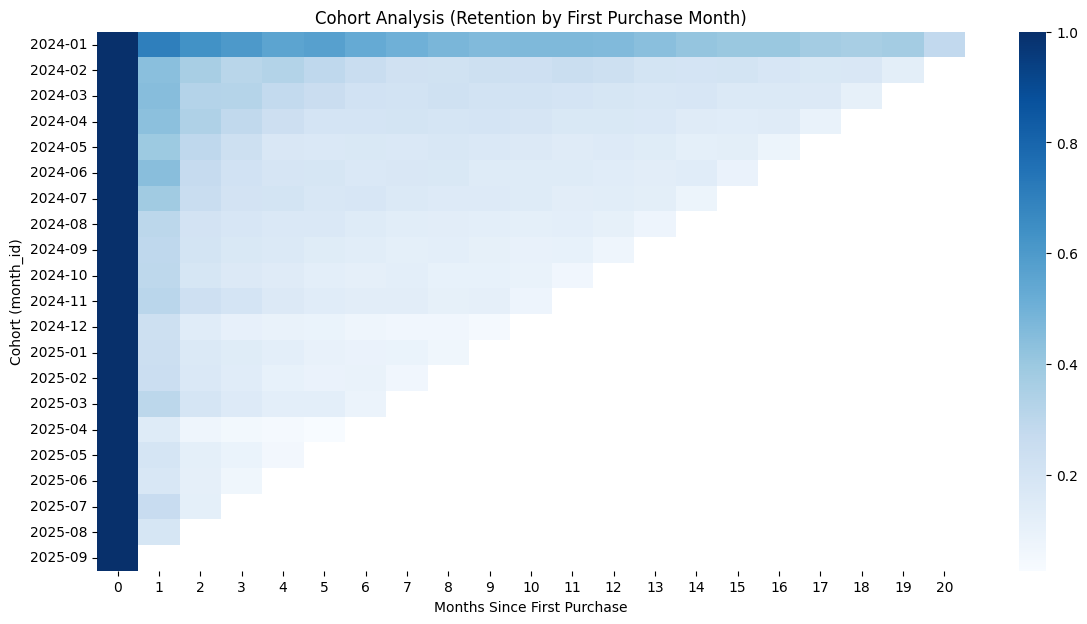

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format="%Y-%m")

data = data[data['day_id'] >= "2024-01-01"]

data['cohort_month'] = data.groupby('player_id')['month_id'].transform('min')

data['cohort_index'] = ((data['month_id'].dt.year - data['cohort_month'].dt.year) * 12 +
                        (data['month_id'].dt.month - data['cohort_month'].dt.month))

cohort_data = (data.groupby(['cohort_month', 'cohort_index'])['player_id']
                  .nunique()
                  .reset_index())

cohort_pivot = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='player_id'
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

plt.figure(figsize=(14,7))
sns.heatmap(retention, annot=False, cmap="Blues")  # annot=False hides values

plt.yticks(
    ticks=[i + 0.5 for i in range(len(retention.index))],
    labels=[d.strftime("%Y-%m") for d in retention.index],
    rotation=0
)

plt.title("Cohort Analysis (Retention by First Purchase Month)")
plt.ylabel("Cohort (month_id)")
plt.xlabel("Months Since First Purchase")
plt.show()


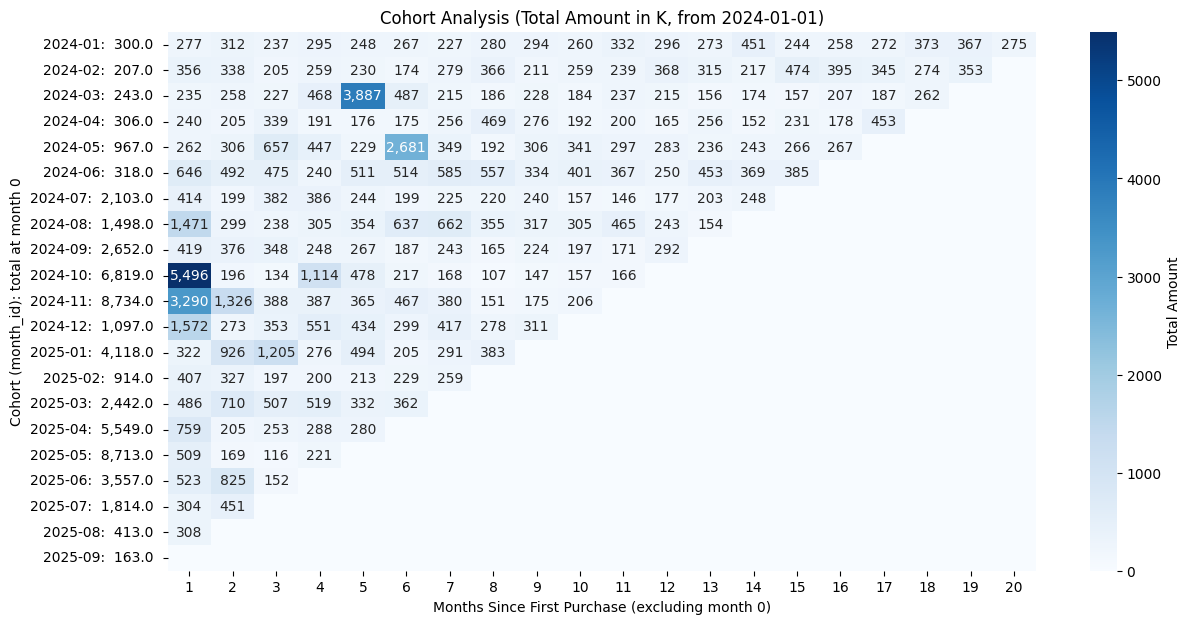

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format="%Y-%m")

min_date = "2024-01-01"
data = data[data['day_id'] >= min_date]

data['cohort_month'] = data.groupby('player_id')['month_id'].transform('min')

data['cohort_index'] = ((data['month_id'].dt.year - data['cohort_month'].dt.year) * 12 +
                        (data['month_id'].dt.month - data['cohort_month'].dt.month))

cohort_data = (data.groupby(['cohort_month', 'cohort_index'])['tot_amount']
                  .mean()
                  .reset_index())

cohort_pivot = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='tot_amount',
    fill_value=0
)/1000

cohort_pivot = cohort_pivot.round(0)

month_0_values = cohort_pivot[0]
formatted_values = month_0_values.apply(lambda x: f"{x:,}")
y_labels = [f"{d.strftime('%Y-%m')}:  {val} " for d, val in zip(cohort_pivot.index, formatted_values)]

heatmap_data = cohort_pivot.drop(columns=0)

plt.figure(figsize=(14,7))

fmt = lambda x: f"{int(x):,}" if x != 0 else ""

sns.heatmap(heatmap_data, annot=True, fmt="", cmap="Blues",
            annot_kws={"size": 10},
            cbar_kws={'label': 'Total Amount'})

for text, val in zip(plt.gca().texts, heatmap_data.to_numpy().flatten()):
    text.set_text(fmt(val))

plt.yticks(
    ticks=[i + 0.5 for i in range(len(heatmap_data.index))],
    labels=y_labels,
    rotation=0
)

plt.title(f"Cohort Analysis (Total Amount in K, from {min_date})")
plt.ylabel("Cohort (month_id): total at month 0")
plt.xlabel("Months Since First Purchase (excluding month 0)")
plt.show()


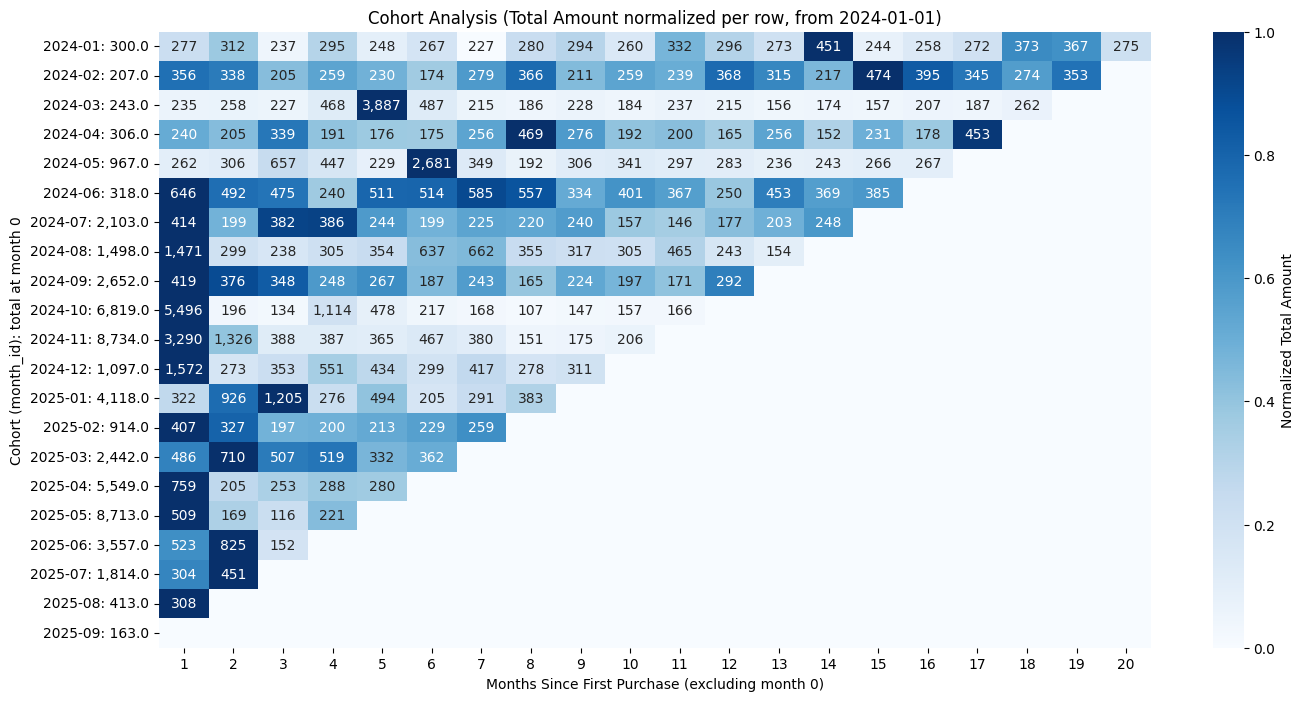

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format="%Y-%m")

min_date = "2024-01-01"
data = data[data['day_id'] >= min_date]

data['cohort_month'] = data.groupby('player_id')['month_id'].transform('min')

data['cohort_index'] = ((data['month_id'].dt.year - data['cohort_month'].dt.year) * 12 +
                        (data['month_id'].dt.month - data['cohort_month'].dt.month))

cohort_data = (data.groupby(['cohort_month', 'cohort_index'])['tot_amount']
                  .mean()
                  .reset_index())

cohort_pivot = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='tot_amount',
    fill_value=0
)/1000

cohort_pivot = cohort_pivot.round(0)

month_0_values = cohort_pivot[0]
formatted_values = month_0_values.apply(lambda x: f"{x:,}")
y_labels = [f"{d.strftime('%Y-%m')}: {val}" for d, val in zip(cohort_pivot.index, formatted_values)]

heatmap_data_raw = cohort_pivot.drop(columns=0)

def min_max_norm(row):
    min_val = row.min()
    max_val = row.max()
    if max_val == min_val:
        return np.zeros_like(row)  # Avoid division by zero if all equal
    return (row - min_val) / (max_val - min_val)

heatmap_data_norm = heatmap_data_raw.apply(min_max_norm, axis=1)

plt.figure(figsize=(16,8))

fmt = lambda x: f"{int(x):,}" if x != 0 else ""

sns.heatmap(heatmap_data_norm, annot=True, fmt="", cmap="Blues",
            annot_kws={"size": 10},
            cbar_kws={'label': 'Normalized Total Amount'})

for text, val in zip(plt.gca().texts, heatmap_data_raw.to_numpy().flatten()):
    text.set_text(fmt(val))

plt.yticks(
    ticks=[i + 0.5 for i in range(len(heatmap_data_norm.index))],
    labels=y_labels,
    rotation=0
)

plt.title(f"Cohort Analysis (Total Amount normalized per row, from {min_date})")
plt.ylabel("Cohort (month_id): total at month 0")
plt.xlabel("Months Since First Purchase (excluding month 0)")
plt.show()


# Modelling with Machine Learning and Feature Importance 

In [223]:
data.sample(5)

,player_id,day_id,player_id_1,tot_amount,day_id_new,month_id,month
158133,4235,2022-09-09,4235,114820,2022-09-09,2022-09,2022-09
1455821,217488,2025-06-08,217488,69178,2025-06-08,2025-06,2025-06
1850014,341964,2024-11-20,341964,12275,2024-11-20,2024-11,2024-11
2981952,207362,2023-12-16,207362,4500,2023-12-16,2023-12,2023-12
1566798,241507,2024-03-11,241507,1020,2024-03-11,2024-03,2024-03


In [225]:
import pandas as pd

data['day_id'] = pd.to_datetime(data['day_id'])

#reference_date = data['day_id'].max() + pd.Timedelta(days=1)

clv_df = data.groupby('player_id').agg(
    recency_days=('day_id', lambda x: (reference_date - x.max()).days),
    frequency=('day_id', 'count'),
    monetary_value=('tot_amount', 'mean'),
    total_value=('tot_amount', 'sum'),
    first_purchase=('day_id', 'min'),
    last_purchase=('day_id', 'max')
).reset_index()

# Calculate tenure in days
clv_df['tenure_days'] = (clv_df['last_purchase'] - clv_df['first_purchase']).dt.days

clv_df.sample()

,player_id,recency_days,frequency,monetary_value,total_value,first_purchase,last_purchase,tenure_days
76268,610051,76,1,4630.0,4630,2025-06-29,2025-06-29,0


In [175]:
#  data['day_id'].max() + pd.Timedelta(days=1)

Mean Squared Error: 49534973223036672.00
R-squared: 0.21


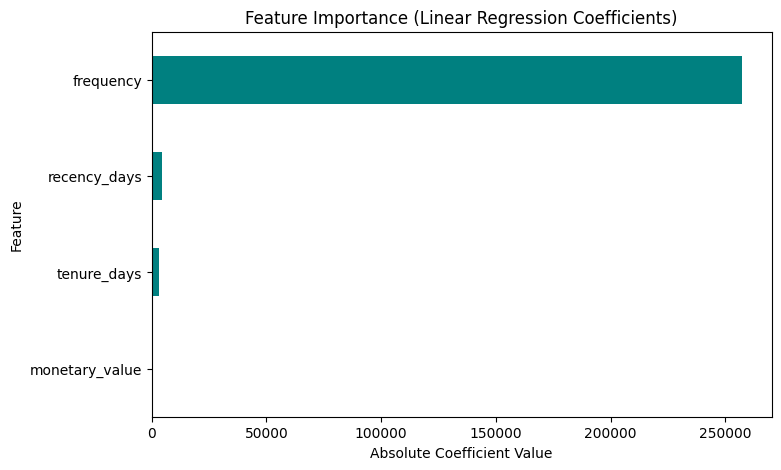

,recency_days,frequency,monetary_value,tenure_days,actual_total_value,predicted_total_value
63292,225,1,26465.0,0,26465,4.492516e+06


In [230]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y-%m')


reference_date = data['day_id'].max() + pd.Timedelta(days=1)

clv_df = data.groupby('player_id').agg(
    recency_days=('day_id', lambda x: (reference_date - x.max()).days),
    frequency=('day_id', 'count'),
    monetary_value=('tot_amount', 'mean'),
    total_value=('tot_amount', 'sum'),
    first_purchase=('day_id', 'min'),
    last_purchase=('day_id', 'max')
).reset_index()

clv_df['tenure_days'] = (clv_df['last_purchase'] - clv_df['first_purchase']).dt.days

features = ['recency_days', 'frequency', 'monetary_value', 'tenure_days']
X = clv_df[features]
y = clv_df['total_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

coef = model.coef_
feature_importance = pd.Series(np.abs(coef), index=features).sort_values(ascending=True)

plt.figure(figsize=(8,5))
feature_importance.plot(kind='barh', color='teal')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

results = X_test.copy()
results['actual_total_value'] = y_test
results['predicted_total_value'] = y_pred
results.sample()

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y-%m')

reference_date = data['day_id'].max() + pd.Timedelta(days=1)

clv_df = data.groupby('player_id').agg(
    recency_days=('day_id', lambda x: (reference_date - x.max()).days),
    frequency=('day_id', 'count'),
    monetary_value=('tot_amount', 'mean'),
    total_value=('tot_amount', 'sum'),
    first_purchase=('day_id', 'min'),
    last_purchase=('day_id', 'max')
).reset_index()

clv_df['tenure_days'] = (clv_df['last_purchase'] - clv_df['first_purchase']).dt.days

data_sorted = data.sort_values(['player_id', 'day_id'], ascending=[True, False])

feature_rows = []
player_ids = data_sorted['player_id'].unique()

for pid in player_ids:
    player_data = data_sorted[data_sorted['player_id'] == pid]
    amounts = player_data['tot_amount'].values
    dates = player_data['day_id'].values
    
    last_amt = amounts[0] if len(amounts) > 0 else np.nan
    second_last_amt = amounts[1] if len(amounts) > 1 else np.nan
    avg_last_2 = np.nanmean(amounts[:2]) if len(amounts) > 1 else last_amt
    total_last_3 = np.nansum(amounts[:3])
    
    freq_30 = player_data[player_data['day_id'] >= (reference_date - pd.Timedelta(days=30))].shape[0]
    freq_90 = player_data[player_data['day_id'] >= (reference_date - pd.Timedelta(days=90))].shape[0]
    
    max_amt = np.max(amounts)
    min_amt = np.min(amounts)
    std_amt = np.std(amounts) if len(amounts) > 1 else 0
    avg_before_last = np.nanmean(amounts[1:]) if len(amounts) > 1 else np.nan
    
    feature_rows.append({
        'player_id': pid,
        'last_purchase_amount': last_amt,
        'second_last_purchase_amount': second_last_amt,
        'average_last_2_amounts': avg_last_2,
        'total_amount_last_3_purchases': total_last_3,
        'frequency_last_30_days': freq_30,
        'frequency_last_90_days': freq_90,
        'max_purchase_amount': max_amt,
        'min_purchase_amount': min_amt,
        'std_purchase_amount': std_amt,
        'average_purchase_amount_before_last': avg_before_last
    })

new_features_df = pd.DataFrame(feature_rows)

clv_full = clv_df.merge(new_features_df, on='player_id', how='left')

features = [
    'recency_days', 'frequency', 'monetary_value', 'tenure_days',
    'last_purchase_amount', 'second_last_purchase_amount', 'average_last_2_amounts',
    'total_amount_last_3_purchases', 'frequency_last_30_days', 'frequency_last_90_days',
    'max_purchase_amount', 'min_purchase_amount', 'std_purchase_amount',
    'average_purchase_amount_before_last'
]

X = clv_full[features]
y = clv_full['total_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

import matplotlib.pyplot as plt
import numpy as np

coef = model.coef_
feature_importance = pd.Series(np.abs(coef), index=features).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='royalblue')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

results = X_test.copy()
results['actual_total_value'] = y_test
results['predicted_total_value'] = y_pred
print(results)


KeyboardInterrupt: 

Mean Squared Error: 11668079310808014.00
R-squared: 0.74


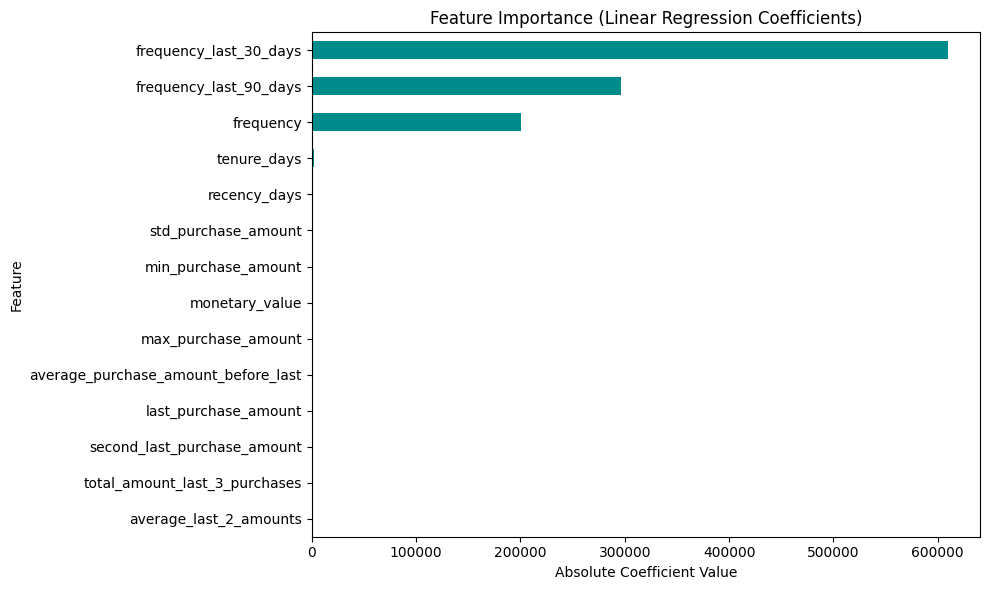

       recency_days  frequency  monetary_value  tenure_days  last_purchase_amount  second_last_purchase_amount  average_last_2_amounts  total_amount_last_3_purchases  frequency_last_30_days  frequency_last_90_days  max_purchase_amount  min_purchase_amount  std_purchase_amount  average_purchase_amount_before_last  actual_total_value  predicted_total_value
19534           258        132     5415.007576          746                  1500                        500.0                  1000.0                           3000                       0                       0                98520                   10         1.309584e+04                          5444.893130              714781           2.397356e+07
65370           200          3    18150.000000            3                  1510                      10980.0                  6245.0                          54450                       0                       0                41960                 1510         2.115673e+04          

In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Convert dates
data['day_id'] = pd.to_datetime(data['day_id'])
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y-%m')

# Reference date
reference_date = data['day_id'].max() + pd.Timedelta(days=1)

clv_df = data.groupby('player_id').agg(
    recency_days=('day_id', lambda x: (reference_date - x.max()).days),
    frequency=('day_id', 'count'),
    monetary_value=('tot_amount', 'mean'),
    total_value=('tot_amount', 'sum'),
    first_purchase=('day_id', 'min'),
    last_purchase=('day_id', 'max')
).reset_index()

clv_df['tenure_days'] = (clv_df['last_purchase'] - clv_df['first_purchase']).dt.days

data_sorted = data.sort_values(['player_id', 'day_id'], ascending=[True, False])


def last_n_amounts(x, n):
    return x.head(n).values

# 1) Last purchase amount
last_purchase = data_sorted.groupby('player_id')['tot_amount'].first().rename('last_purchase_amount')

# 2) Second last purchase amount
def second_last(x):
    return x.iloc[1] if len(x) > 1 else np.nan
second_last_purchase = data_sorted.groupby('player_id')['tot_amount'].apply(second_last).rename('second_last_purchase_amount')

# 3) Average last 2 purchase amounts
def avg_last_2(x):
    return x.head(2).mean()
avg_last_2_amounts = data_sorted.groupby('player_id')['tot_amount'].apply(avg_last_2).rename('average_last_2_amounts')

# 4) Total amount last 3 purchases
def sum_last_3(x):
    return x.head(3).sum()
total_amount_last_3 = data_sorted.groupby('player_id')['tot_amount'].apply(sum_last_3).rename('total_amount_last_3_purchases')

# 5 & 6) Frequency in last 30 and 90 days
def freq_in_period(x, days):
    cutoff = reference_date - pd.Timedelta(days=days)
    return (x >= cutoff).sum()

freq_last_30 = data_sorted.groupby('player_id')['day_id'].apply(lambda x: freq_in_period(x, 30)).rename('frequency_last_30_days')
freq_last_90 = data_sorted.groupby('player_id')['day_id'].apply(lambda x: freq_in_period(x, 90)).rename('frequency_last_90_days')

# 7) Max purchase amount
max_purchase = data.groupby('player_id')['tot_amount'].max().rename('max_purchase_amount')

# 8) Min purchase amount
min_purchase = data.groupby('player_id')['tot_amount'].min().rename('min_purchase_amount')

# 9) Std dev of purchase amount
std_purchase = data.groupby('player_id')['tot_amount'].std().fillna(0).rename('std_purchase_amount')

# 10) Average purchase amount excluding last
def avg_excluding_last(x):
    if len(x) <= 1:
        return np.nan
    return x.iloc[1:].mean()
avg_purchase_before_last = data_sorted.groupby('player_id')['tot_amount'].apply(avg_excluding_last).rename('average_purchase_amount_before_last')

# Combine all new features into one DataFrame
new_features_df = pd.concat([
    last_purchase,
    second_last_purchase,
    avg_last_2_amounts,
    total_amount_last_3,
    freq_last_30,
    freq_last_90,
    max_purchase,
    min_purchase,
    std_purchase,
    avg_purchase_before_last
], axis=1).reset_index()

# Merge with base CLV features
clv_full = clv_df.merge(new_features_df, on='player_id', how='left')
clv_full = clv_full.dropna()

# Modeling
features = [
    'recency_days', 'frequency', 'monetary_value', 'tenure_days',
    'last_purchase_amount', 'second_last_purchase_amount', 'average_last_2_amounts',
    'total_amount_last_3_purchases', 'frequency_last_30_days', 'frequency_last_90_days',
    'max_purchase_amount', 'min_purchase_amount', 'std_purchase_amount',
    'average_purchase_amount_before_last'
]

X = clv_full[features]
y = clv_full['total_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred):.2f}")

# Feature importance plot
coef = model.coef_
feature_importance = pd.Series(np.abs(coef), index=features).sort_values()

plt.figure(figsize=(10,6))
feature_importance.plot(kind='barh', color='darkcyan')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Show predictions vs actuals
results = X_test.copy()
results['actual_total_value'] = y_test
results['predicted_total_value'] = y_pred
results.sample()

# NBD Tests

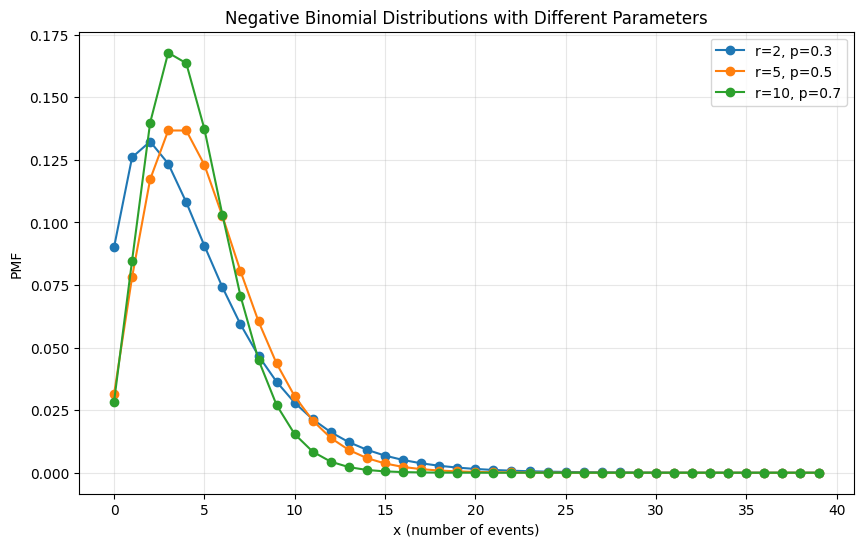

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

x = np.arange(0, 40)

params = [
    (2, 0.3),   # overdispersed
    (5, 0.5),   # moderate
    (10, 0.7),  # higher r, lower variance
]

plt.figure(figsize=(10, 6))

# Loop through parameter sets
for r, p in params:
    pmf = nbinom.pmf(x, r, p)
    plt.plot(x, pmf, marker="o", label=f"r={r}, p={p}")

plt.title("Negative Binomial Distributions with Different Parameters")
plt.xlabel("x (number of events)")
plt.ylabel("PMF")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


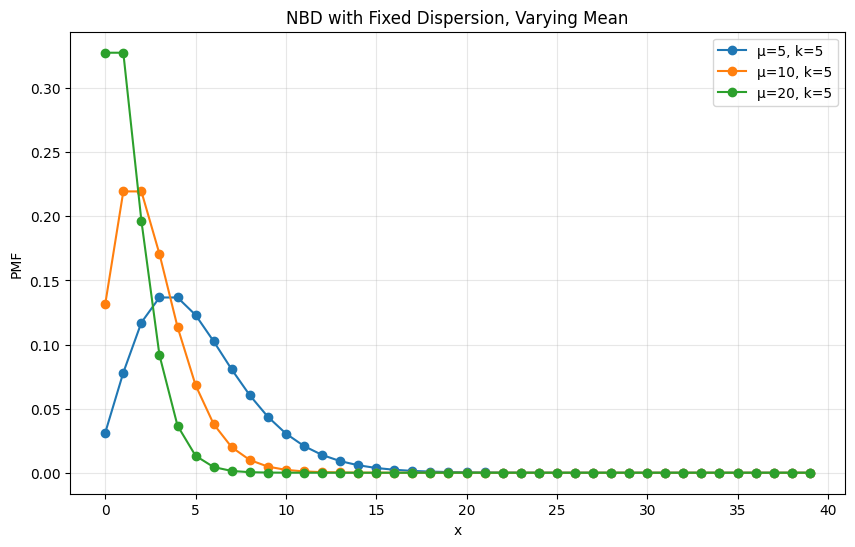

In [47]:
def mu_k_to_rp(mu, k):
    # Convert (mean, dispersion) -> (r, p)
    r = k
    p = mu / (mu + k)
    return r, p

x = np.arange(0, 40)
mus = [5, 10, 20]
k = 5  # fixed dispersion

plt.figure(figsize=(10, 6))
for mu in mus:
    r, p = mu_k_to_rp(mu, k)
    pmf = nbinom.pmf(x, r, p)
    plt.plot(x, pmf, marker="o", label=f"μ={mu}, k={k}")

plt.title("NBD with Fixed Dispersion, Varying Mean")
plt.xlabel("x")
plt.ylabel("PMF")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
